# CUNEF MUCD 2022/2023
# Machine Learning
# Análisis de Fraude

### Autores:
- Gozde Yazganoglu
- Irma Sanchez



# Importación de Librerías

In [2]:
import pandas as pd
import numpy as np
import sweetviz as sv
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import sklearn

### Importación de Dataset y Diccionario

In [3]:
data = pd.read_csv('../data/raw/Copia de Original_dataset_payments_fraud.csv', sep=";")
print("El dataset está compuesto por", len(data.index), "filas y", len(data.columns), "columnas")
data.head()

El dataset está compuesto por 1048575 filas y 19 columnas


,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,newbalanceOrig,zone,user_number,nameDest,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,man,mac,"0,140039412",C1231006815,black,170136.0,85,160296.36,capital,138,M1979787155,5,1,0.0,0.0,0
1,1,PAYMENT,1864.28,woman,mac,"0,496889534",C1666544295,asian,21249.0,57,19384.72,country,909,M2044282225,1,0,0.0,0.0,0
2,1,TRANSFER,181.00,man,pc,"0,781150327",C1305486145,asian,181.0,66,0.00,capital,2569,C553264065,10,0,0.0,0.0,1
3,1,CASH_OUT,181.00,man,mac,"0,565068378",C840083671,black,181.0,31,0.00,country,1787,C38997010,3,0,21182.0,0.0,1
4,1,PAYMENT,11668.14,unknow,mac,"0,517114493",C2048537720,black,41554.0,90,29885.86,country,3997,M1230701703,8,0,0.0,0.0,0


In [5]:
dictionary = pd.read_excel('../data/raw/initial variables.xlsx')

dictionary

,Variable,Description,Type,Values
0,step,unidad de tiempo 1 = 1 hora,Numerical,"[1, 95]"
1,type,tipo,Categorical,"CASH_IN, CASH_OUT, TRANSFER, PAYMENT, DEBIT"
2,amount,cantidad,Numerical,"[10.48 , 10000000.00]"
3,gender,género (informado por el cliente),Categorical,"man, woman, unknown + (null values)"
4,device,tipo del dispositivo que inicio la transacción,Categorical,"mac, iphone, pc + (null values)"
5,connection_time,segundos que tardan en llegar los datos desde...,Numerical,"[ 0,0000282433 , 0,999999999]"
6,nameOrig,identificador del cliente que inicia la trans...,Categorical,Customer id with letter and numbers
7,race,raza,Categorical,"asian, black, latin + (null values)"
8,oldbalanceOrg,saldo antes de la transacción,Numerical,fom 0.0 to 1.05E+ 15
9,age,edad estimada,Numerical,"[5, 100]"


Echamos un vistazo rápido con sweetviz. Resultados están en el archivo 'html'.

In [4]:
#analyze_report=sv.analyze(data)
#analyze_report.show_html('primer_analisis.html')


# Comentamos el codigo porque se trabaja mejor así. El resultado esta en htmls. En caso de necesidad se puede executar tambien.

# Variable Objectivo y Problema de Negocio

Tras ver el análsis obtenido con sweetviz, podemos ver que existe un pequeño porcentaje de transacciones (menos del 0,1%) que pueden acabar siendo fraude.
Pero una transacción fraudulenta pueda causar pérdidas millonarias y genera un gran efecto sobre los clientes y el banco ( empeora su reputación...)
Además, el banco puede quedar en la posicion  de hacerse responsable de las pérdidas de los clientes. Por tanto, si se consigue prevenir el fraude, mejor. 
Nuestra variable objetivo de la base de datos empleada es 'isFraud'. A continuación, la analizaremos.

In [5]:
data['isFraud'].value_counts()

df_objective = data ['isFraud'].value_counts(normalize=True).mul(100).rename('percent').reset_index()
df_objective_count = data['isFraud'].value_counts().reset_index()
df_objective_pc = pd.merge(df_objective, df_objective_count, on=['index'], how='inner')
df_objective_pc



,index,percent,isFraud
0,0,99.89109,1047433
1,1,0.10891,1142


In [6]:
fig = px.histogram(df_objective_pc, x='index', y=['percent'], labels={'index':'Fraud'})
fig.show()



# Features

In [7]:
data.dtypes.sort_values().to_frame('feature_type').groupby(by = 'feature_type').size().to_frame('count').reset_index()

,feature_type,count
0,int64,6
1,float64,5
2,object,8


Las variables que componen nuestro dataset son: 8 variables categóricas, 10 numéricas

In [8]:
data_dtypes = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
                             data.dtypes.to_frame('feature_type').reset_index(),
                             on = 'index',
                             how = 'inner')

In [9]:
data_dtypes.sort_values(['missing_value', 'feature_type'])

,index,missing_value,feature_type
0,step,0,int64
2,security_alert,0,int64
3,user_connections,0,int64
5,user_number,0,int64
8,age,0,int64
14,isFraud,0,int64
1,oldbalanceDest,0,float64
6,newbalanceOrig,0,float64
7,newbalanceDest,0,float64
11,amount,0,float64


# Duplicate Columns

In [10]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            ia = vs.iloc[:,i].values
            for j in range(i+1, lcs):
                ja = vs.iloc[:,j].values
                if np.array_equal(ia, ja):
                    dups.append(cs[i])
                    break
    return dups

In [11]:
duplicate_cols = duplicate_columns(data)
duplicate_cols

[]

No existe columnas duplicadas

# Analisis de Nulos

En esta sección vamos a valorar y transformar las variables con nulos. Según los resultados de Sweetviz y de nuestro codigo, 'zone', 'device', 'gender', 'race' tienen valores nulos. Sexo y Raza pueden ser nulos, porque a veces la gente no quiere compartir este tipo de informacion, para evitar la discriminacion o simplemetente porque no se sineten identificados con ningún sexo. Creemos que no puede tener un efecto grande, pero como no tenemos muchos fraudes, cuanta más información dispongamos mejor. Por eso dejamos raza y sexo. Vamos a llamar valores nulos como 'Unknow' para gender y 'Other' para raza.

Zona sin embargo, sí que puede ser importante.La mayoría de las transacciones fraudes suelen ocurrir en sitios lejanos. Por ejemplo, la mayoría de las transacciones bancarias son SWIFT o con tarjeta de crédito, PayPal...etc. Mayoría de los alternativos son productos de empresas en EEUU. Estas empresas no pueden hacer transacciones con países no permitidos o cuentas relacionadas con grupos teroristas. Por eso,que haya fraude es más fácil en algunos sitios que los otros. Por otra parte, los ladrones  cada vez emplean tecnología más inteligente y pueden evitar las barreras  o utilizar VPN. Por eso puede ser difícl detectarlo. En nuestra caso vamos a llamar los nulos como 'Unknown'.

La variable 'Tipo de dispositivo' puede ser también importante. Algunos dispositivos pueden ser más fáciles de hackear que  otros, y puede cambiar el resultado de fraude. Los dispositivos que no sabemos los llamamos 'Unknown' o 'Other'.

En este caso quitar nulos nos hace perder mucha información, por ello vamos a evitarlo.

In [12]:
data = data.fillna({
    'gender' : 'unknow',
    'race' : 'other',
    'zone' : 'unknown',
    'device' : 'other',
    
})


In [13]:
data_dtypes_n = pd.merge(data.isnull().sum(axis = 0).sort_values().to_frame('missing_value').reset_index(),
                             data.dtypes.to_frame('feature_type').reset_index(),
                             on = 'index',
                             how = 'inner')
data_dtypes_n

,index,missing_value,feature_type
0,step,0,int64
1,oldbalanceDest,0,float64
2,security_alert,0,int64
3,user_connections,0,int64
4,nameDest,0,object
5,user_number,0,int64
6,zone,0,object
7,newbalanceOrig,0,float64
8,newbalanceDest,0,float64
9,age,0,int64


Ya no tenemos valores nulos.

#  Variables Categoricos

In [14]:
data.connection_time.head()

0    0,140039412
1    0,496889534
2    0,781150327
3    0,565068378
4    0,517114493
Name: connection_time, dtype: object

Aparentemente connection_time esta clasificado como object por culpa de estar con coma en vez de con punto. Deberíamos ver este variable como numeric. Porque duracion de connection puede efectar positivamente o negativamente.

In [15]:
data = data.assign(**{'connection_time': lambda data: data['connection_time'].str.replace(',', '.').astype(float)})
data.connection_time.head()

0    0.140039
1    0.496890
2    0.781150
3    0.565068
4    0.517114
Name: connection_time, dtype: float64

In [16]:
data.nameOrig.head()

0    C1231006815
1    C1666544295
2    C1305486145
3     C840083671
4    C2048537720
Name: nameOrig, dtype: object

In [17]:
data.nameDest.head()

0    M1979787155
1    M2044282225
2     C553264065
3      C38997010
4    M1230701703
Name: nameDest, dtype: object

nameDest y nameOrig son variables, identificadores para los clientes. Sería preferible conocer el significado de las letras o números, ya que en algunos bancos, el número de cliente nos da mucha informacion. Además, las letras pueden significar el tipo de cliente o si es cliente de este banco o otro banco...etc. Esta información sería muy importante.(Depende de resultados pudieramos ofrecir a los clientes o clientes de otro bancos diferente, por que tienen protocoles de seguridad diferente). Pero con la informacion que tenemos, no lo podemos utilizar. 

A lo mejor algunos clientes reciben más transacciones con fraude porque no estan cuidando a su seguridad tanto. O atacadores roban directamente estos clientes Pero con este porcentaje de fraudes y némero de clientes(nameOrig tiene mas de 1 millon valores diferentes), no podemos detectar. Por eso, decidimos quitar estas variables.

In [18]:
from sklearn import preprocessing


Para poder ver la correlacion implementamos label encoding solo en las variables categóricas para que el algoritmo pueda entender.En este momento no tocamos el dataset.

In [19]:
#Label encoding los variables, numerizacion. Para ver correlaciones.

le_nameDest = preprocessing.LabelEncoder()
le_nameOrig = preprocessing.LabelEncoder()
le_type = preprocessing.LabelEncoder()
le_gender = preprocessing.LabelEncoder()
le_race = preprocessing.LabelEncoder()
le_zone = preprocessing.LabelEncoder()
le_device = preprocessing.LabelEncoder()


In [20]:
data_cat = data.filter(items=['nameDest-n','nameOrig-n', 'type-n','gender-n','race-n','zone-n', 'device-n', 'isFraud'])

data_cat.head()

,isFraud
0,0
1,0
2,1
3,1
4,0


In [21]:
data['nameDest-n'] = le_nameDest.fit_transform(data['nameDest'])
data['nameOrig-n'] = le_nameOrig.fit_transform(data['nameOrig'])
data['type-n'] = le_type.fit_transform(data['type'])
data['gender-n'] = le_gender.fit_transform(data['gender'])
data['race-n'] = le_race.fit_transform(data['race'])
data['zone-n'] = le_zone.fit_transform(data['zone'])
data['device-n'] = le_device.fit_transform(data['device'])
data.head()

,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,oldbalanceDest,newbalanceDest,isFraud,nameDest-n,nameOrig-n,type-n,gender-n,race-n,zone-n,device-n
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.0,85,...,0.0,0.0,0,274917,125164,3,0,1,1,1
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.0,57,...,0.0,0.0,0,286716,361319,3,2,0,2,1
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.0,66,...,0.0,0.0,1,73550,165236,4,0,0,1,3
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.0,31,...,21182.0,0.0,1,65464,961662,1,0,1,2,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.0,90,...,0.0,0.0,0,138001,567915,3,1,1,2,1


In [22]:
data_cat = data.filter(items=['nameDest-n','nameOrig-n', 'type-n','gender-n','race-n','zone-n', 'device-n', 'isFraud'])

data_cat.head()
data_numeric = data.drop(columns = ['nameDest-n','nameOrig-n', 'type-n','gender-n','race-n','zone-n', 'device-n', 'nameDest','nameOrig', 'type','gender','race','zone', 'device'])

data_numeric.head()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
0,1,9839.64,0.140039,170136.0,85,160296.36,138,5,1,0.0,0.0,0
1,1,1864.28,0.496890,21249.0,57,19384.72,909,1,0,0.0,0.0,0
2,1,181.00,0.781150,181.0,66,0.00,2569,10,0,0.0,0.0,1
3,1,181.00,0.565068,181.0,31,0.00,1787,3,0,21182.0,0.0,1
4,1,11668.14,0.517114,41554.0,90,29885.86,3997,8,0,0.0,0.0,0


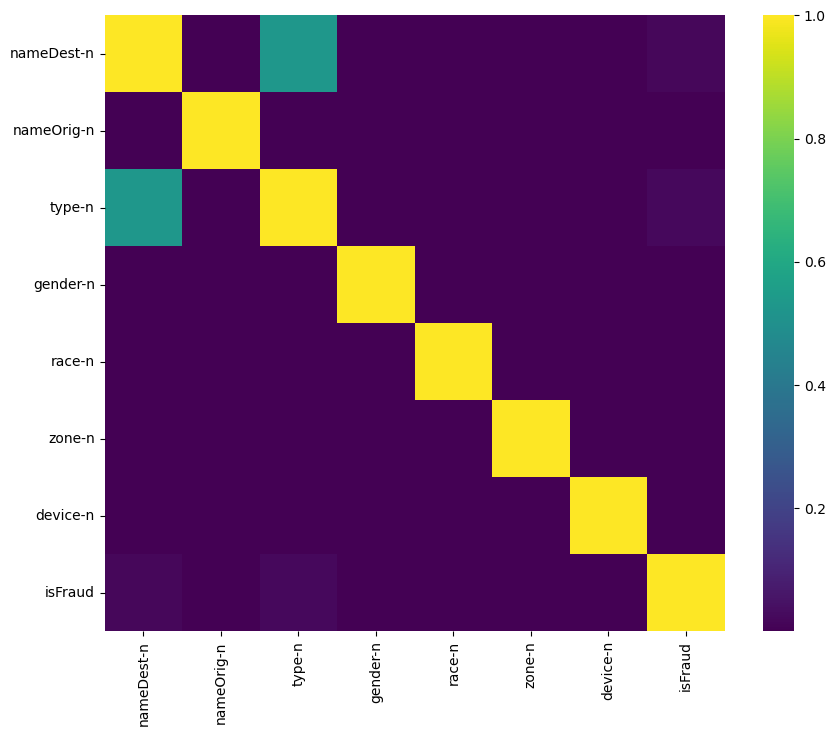

In [23]:
corr_cat = data_cat.corr(method = 'spearman')

plt.figure(figsize = (10, 8))
sns.heatmap(corr_cat.abs(), cmap ='viridis' )
plt.show()


Podemos observar que la variable type es muy importante, ya que esta relacionada con cuenta de destino. Esto puede deberse a que los estafadores o ladrones no lo han hecho una sola vez.


# Variables Numericos

Por datos numéricos calculamos correlación de pearson


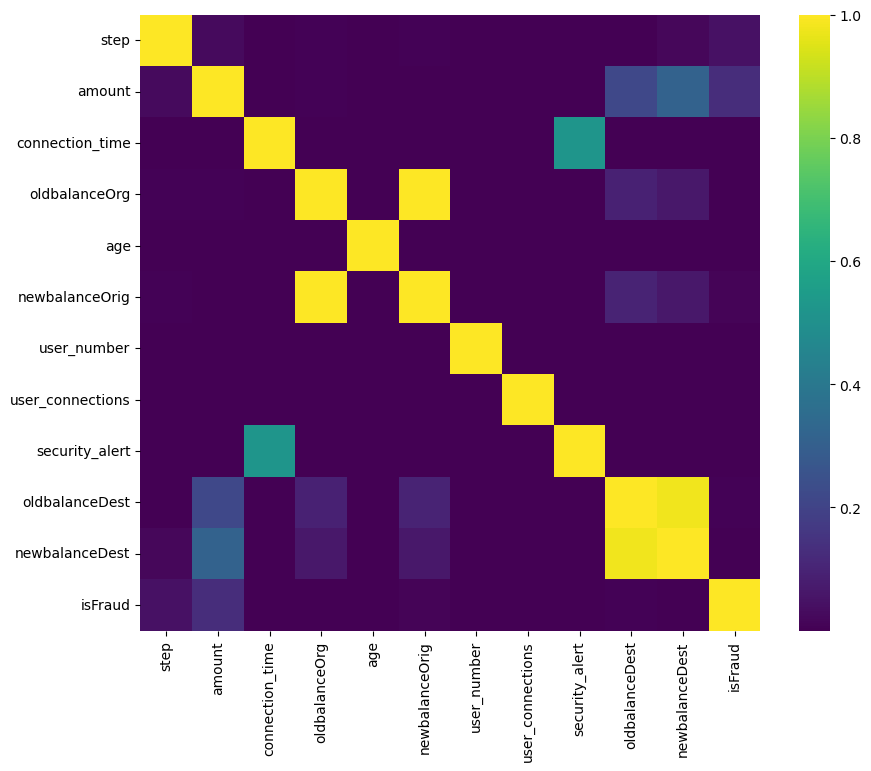

In [24]:
corr_num = data_numeric.corr(method = 'pearson')

plt.figure(figsize = (10, 8))
sns.heatmap(corr_num.abs(), cmap ='viridis' )
plt.show()


In [25]:
print("El dataset está compuesto por", len(data.index), "filas y", len(data.columns), "columnas")
data.head()

El dataset está compuesto por 1048575 filas y 26 columnas


,step,type,amount,gender,device,connection_time,nameOrig,race,oldbalanceOrg,age,...,oldbalanceDest,newbalanceDest,isFraud,nameDest-n,nameOrig-n,type-n,gender-n,race-n,zone-n,device-n
0,1,PAYMENT,9839.64,man,mac,0.140039,C1231006815,black,170136.0,85,...,0.0,0.0,0,274917,125164,3,0,1,1,1
1,1,PAYMENT,1864.28,woman,mac,0.496890,C1666544295,asian,21249.0,57,...,0.0,0.0,0,286716,361319,3,2,0,2,1
2,1,TRANSFER,181.00,man,pc,0.781150,C1305486145,asian,181.0,66,...,0.0,0.0,1,73550,165236,4,0,0,1,3
3,1,CASH_OUT,181.00,man,mac,0.565068,C840083671,black,181.0,31,...,21182.0,0.0,1,65464,961662,1,0,1,2,1
4,1,PAYMENT,11668.14,unknow,mac,0.517114,C2048537720,black,41554.0,90,...,0.0,0.0,0,138001,567915,3,1,1,2,1


La matriz de correlación nos muestra que la variable más relevante es amount. Los new balances y old balances están correlados.


In [26]:
# Histogram with Kernel Density Estimate Plot (KDE)
# Source: https://stackoverflow.com/questions/43638851/pandas-histogram-plot-with-kde
def plot_histograms(df, columns):
    # keep total number of subplot
    k = len(df.columns)
    # n = number of chart columns
    n = columns
    m = (k - 1) // n + 1
    
    # Create figure
    fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))

    # Iterate through columns, tracking the column name and 
    # which number we are at i. Within each iteration, plot
    for i, (name, col) in enumerate(df.iteritems()):
        r, c = i // n, i % n
        ax = axes[r, c]
        # the histogram
        col.hist(ax=ax)
        
        # kde = Kernel Density Estimate plot
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=name)
        ax2.set_ylim(0)
        
        

    # Use tight_layout() as an easy way to sharpen up the layout spacing
    fig.tight_layout()

Guardamos el dataset en parquet para poder utilizarlo en los siguentes pasos.

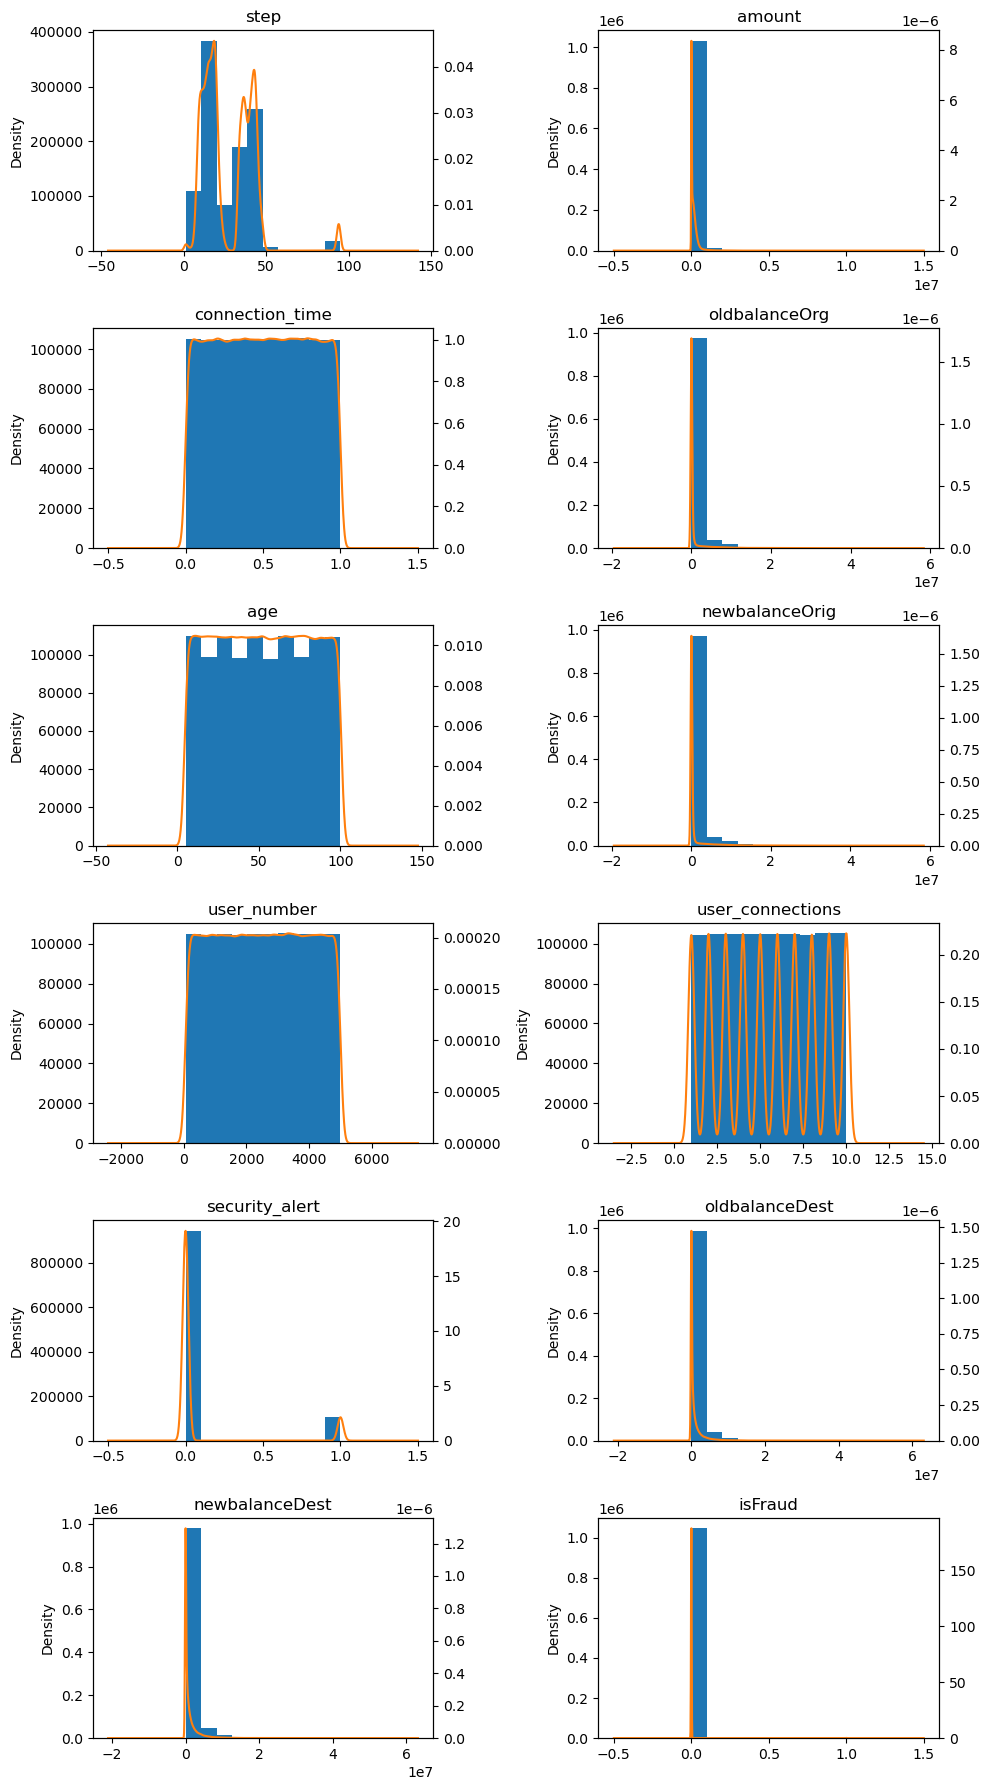

In [27]:
plot_histograms(df=data[['step','amount','connection_time','oldbalanceOrg', 'age', 'newbalanceOrig', 'user_number', 'user_connections','security_alert','oldbalanceDest','newbalanceDest','isFraud']], columns=2)


Cuando echamos un ojo a los distribuciones, vemos que los variables numericos no son normales. Algunos valores sale muy frequente y el otros muy poco. Es porque los fradulent transactiones occurre muy raro y probablemente su indicatores tambien ocurre muy raro. En este caso si quitamos algunos valores como 'outlier' deberiamos tambien quitar todos 1s de variable objectivo 'isFraud' con 0.1% y no podemos encontrar nada. Por eso, en este analisis, deberiamos mantener los outliers. 


In [28]:
data=data.drop(columns = ['nameDest-n','nameOrig-n', 'type-n','gender-n','race-n','zone-n', 'device-n'])

In [29]:
data.describe()

,step,amount,connection_time,oldbalanceOrg,age,newbalanceOrig,user_number,user_connections,security_alert,oldbalanceDest,newbalanceDest,isFraud
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,2.696617e+01,1.586670e+05,5.000671e-01,8.740055e+05,5.245674e+01,8.938049e+05,2.530440e+03,5.503561e+00,1.000453e-01,9.781600e+05,1.114193e+06,1.089097e-03
std,1.562325e+01,2.649409e+05,2.885239e-01,2.971725e+06,2.772639e+01,3.008246e+06,1.426418e+03,2.872241e+00,3.000605e-01,2.296779e+06,2.416554e+06,3.298351e-02
min,1.000000e+00,1.000000e-01,2.618800e-08,0.000000e+00,5.000000e+00,0.000000e+00,5.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.500000e+01,1.214907e+04,2.500884e-01,0.000000e+00,2.800000e+01,0.000000e+00,1.295000e+03,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+01,7.634333e+04,5.003599e-01,1.600200e+04,5.200000e+01,0.000000e+00,2.532000e+03,6.000000e+00,0.000000e+00,1.263772e+05,2.182604e+05,0.000000e+00
75%,3.900000e+01,2.137619e+05,7.496531e-01,1.366420e+05,7.600000e+01,1.746000e+05,3.765000e+03,8.000000e+00,0.000000e+00,9.159235e+05,1.149808e+06,0.000000e+00
max,9.500000e+01,1.000000e+07,9.999991e-01,3.893942e+07,1.000000e+02,3.894623e+07,5.000000e+03,1.000000e+01,1.000000e+00,4.205466e+07,4.216916e+07,1.000000e+00


In [30]:
data.to_parquet("../data/processed/dataset_payments_fraud_processed.parquet")
print('guardado')

guardado


In [33]:
data_selection = data.drop(columns = ['gender','race', 'nameDest','nameOrig'])

data_selection

data_selection.to_parquet('../data/processed/data_selection.parquet')

print('guardado')

guardado
